In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
import torch.nn as nn
from torch.optim import Adam
import sys, os
sys.path.append(os.path.abspath("../src"))
from torch.utils.data import TensorDataset, DataLoader
from node.lib.odst import ODST
import idx2numpy as idx2np

In [7]:
# Load raw IDX files
train_images = idx2np.convert_from_file("../data/mnist-dataset/train-images.idx3-ubyte")
train_labels = idx2np.convert_from_file("../data/mnist-dataset/train-labels.idx1-ubyte")
test_images  = idx2np.convert_from_file("../data/mnist-dataset/t10k-images.idx3-ubyte")
test_labels  = idx2np.convert_from_file("../data/mnist-dataset/t10k-labels.idx1-ubyte")

# Flatten images to (n_samples, 784) and normalize to [0–1]
X_train = train_images.reshape(-1, 28*28).astype(np.float32) / 255.0
X_test  = test_images.reshape(-1, 28*28).astype(np.float32)  / 255.0
y_train = train_labels
y_test  = test_labels

In [9]:
# 3. Initialize & Train TabNet
clf = TabNetClassifier(
    # you can tune these:
    n_d=8,           # width of decision prediction layer
    n_a=8,           # width of attention embedding for tabnet
    n_steps=3,       # number of decision steps
    gamma=1.5,       # relaxation factor
    lambda_sparse=1e-3,
    optimizer_fn=Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax'  # “sparsemax” or “entmax”
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=50,         # increase if necessary
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

/opt/anaconda3/envs/sago/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.07384 | test_accuracy: 0.2507  |  0:00:05s
epoch 1  | loss: 1.15439 | test_accuracy: 0.6546  |  0:00:10s
epoch 2  | loss: 0.62361 | test_accuracy: 0.8513  |  0:00:15s
epoch 3  | loss: 0.4111  | test_accuracy: 0.9074  |  0:00:20s
epoch 4  | loss: 0.33669 | test_accuracy: 0.9262  |  0:00:25s
epoch 5  | loss: 0.27416 | test_accuracy: 0.9355  |  0:00:31s
epoch 6  | loss: 0.24668 | test_accuracy: 0.9436  |  0:00:36s
epoch 7  | loss: 0.22824 | test_accuracy: 0.9452  |  0:00:41s
epoch 8  | loss: 0.20327 | test_accuracy: 0.9507  |  0:00:46s
epoch 9  | loss: 0.18951 | test_accuracy: 0.9528  |  0:00:51s
epoch 10 | loss: 0.16975 | test_accuracy: 0.9574  |  0:00:56s
epoch 11 | loss: 0.1591  | test_accuracy: 0.9566  |  0:01:01s
epoch 12 | loss: 0.14988 | test_accuracy: 0.9582  |  0:01:06s
epoch 13 | loss: 0.14179 | test_accuracy: 0.9596  |  0:01:11s
epoch 14 | loss: 0.13659 | test_accuracy: 0.9599  |  0:01:15s
epoch 15 | loss: 0.13236 | test_accuracy: 0.9611  |  0:01:20s
epoch 16

/opt/anaconda3/envs/sago/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



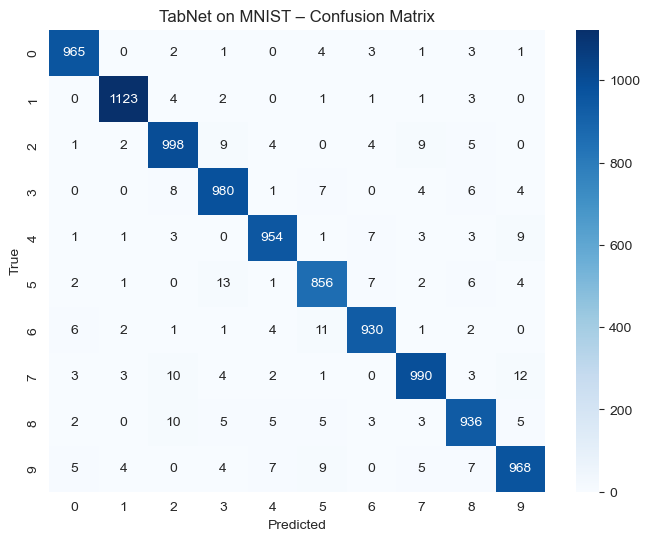

In [10]:
# 4. Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("TabNet on MNIST – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

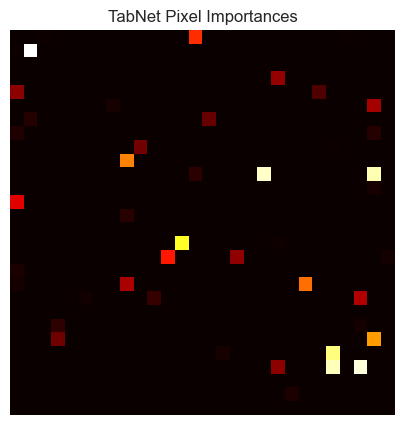

In [11]:
# 5. Feature importance (per-pixel)
feat_imp = clf.feature_importances_.reshape(28,28)
plt.figure(figsize=(5,5))
plt.imshow(feat_imp, cmap='hot')
plt.axis('off')
plt.title("TabNet Pixel Importances")
plt.show()